In [1]:
import pandas as pd
from pmdarima import auto_arima
from prophet import Prophet
import matplotlib.pyplot as plt


In [2]:
df = pd.read_parquet("../../data/processed/revenue_clean.parquet")

In [3]:
train = pd.read_parquet('../../data/processed/train.parquet')
test = pd.read_parquet('../../data/processed/test.parquet')
test.head(3)

,date,cheese_revenue,milk_revenue,dulce_leche_revenue,eggs_revenue,porks_revenue,vegetables_revenue
48,2024-01-01,800,3555,180,180,1500,80
49,2024-02-01,900,3645,150,195,1800,84
50,2024-03-01,1000,3735,195,210,1800,90


In [4]:
X_train = train.drop(columns=["date", "milk_revenue"])
X_test = test.drop(columns=["date", "milk_revenue"])
y_test = test["milk_revenue"]
y_train = train["milk_revenue"]

In [5]:
model = auto_arima(y_train, seasonal=True, m=12)

n_periods = len(y_test)
forecast = model.predict(n_periods=n_periods, X=X_test)
forecast = pd.Series(forecast, index=y_test.index)
forecast

/home/guilherme/Documentos/Cooperativa/venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/guilherme/Documentos/Cooperativa/venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/guilherme/Documentos/Cooperativa/venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/guilherme/Documentos/Cooperativa/venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/guilherme/Documentos/Cooperativa/venv/lib/python3.13/site-packages/sklearn/utils/d

48    3358.19264
49    3358.19264
50    3358.19264
51    3358.19264
52    3358.19264
53    3358.19264
54    3358.19264
55    3358.19264
56    3358.19264
57    3358.19264
58    3358.19264
59    3358.19264
dtype: float64

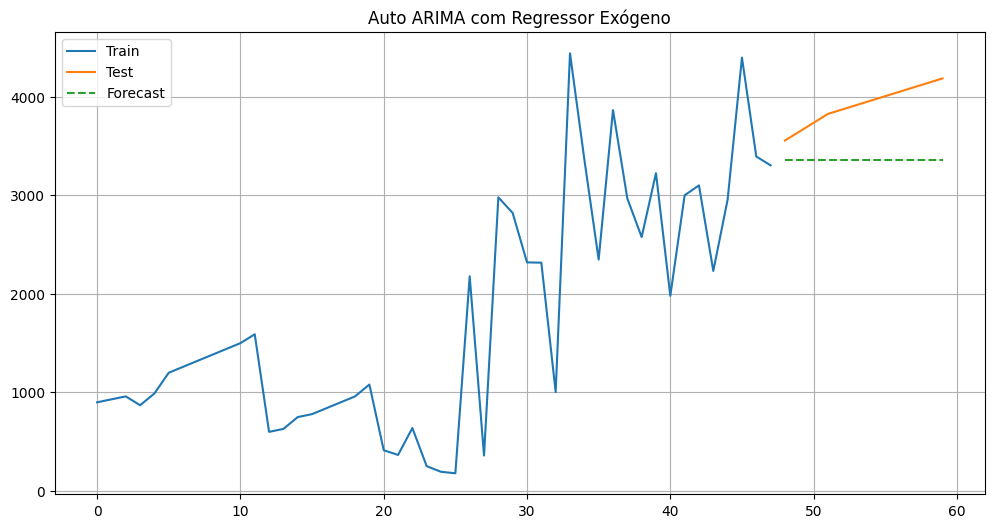

In [6]:
plt.figure(figsize=(12, 6))
plt.plot(y_train, label="Train")
plt.plot(y_test, label="Test")
plt.plot(forecast, label="Forecast", linestyle="--")
plt.legend()
plt.title("Auto ARIMA com Regressor Exógeno")
plt.grid(True)
plt.show()


In [7]:
df_prophet_milk = df.reset_index()[['date', 'milk_revenue']].rename(columns={
    'date': 'ds',
    'milk_revenue': 'y'
})
model_prophet_milk = Prophet()
model_prophet_milk.fit(df_prophet_milk)

10:27:45 - cmdstanpy - INFO - Chain [1] start processing
10:27:45 - cmdstanpy - INFO - Chain [1] done processing


In [8]:
df_prophet_cheese = df.reset_index()[['date', 'cheese_revenue']].rename(columns={
    'date': 'ds',
    'cheese_revenue': 'y'
})
model_prophet_cheese = Prophet()
model_prophet_cheese.fit(df_prophet_cheese)

10:27:46 - cmdstanpy - INFO - Chain [1] start processing
10:27:46 - cmdstanpy - INFO - Chain [1] done processing


In [9]:
df_prophet_porks = df.reset_index()[['date', 'porks_revenue']].rename(columns={
    'date': 'ds',
    'porks_revenue': 'y'
})
model_prophet_porks = Prophet()
model_prophet_porks.fit(df_prophet_porks)

10:27:46 - cmdstanpy - INFO - Chain [1] start processing
10:27:46 - cmdstanpy - INFO - Chain [1] done processing


In [10]:
future_milk = model_prophet_milk.make_future_dataframe(periods=12, freq='M')
forecast_milk = model_prophet_milk.predict(future_milk)

future_cheese = model_prophet_cheese.make_future_dataframe(periods=12, freq='M')
forecast_cheese = model_prophet_cheese.predict(future_cheese)

future_porks = model_prophet_porks.make_future_dataframe(periods=12, freq='M')
forecast_porks = model_prophet_porks.predict(future_porks)

/home/guilherme/Documentos/Cooperativa/venv/lib/python3.13/site-packages/prophet/forecaster.py:1872: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(
/home/guilherme/Documentos/Cooperativa/venv/lib/python3.13/site-packages/prophet/forecaster.py:1872: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(
/home/guilherme/Documentos/Cooperativa/venv/lib/python3.13/site-packages/prophet/forecaster.py:1872: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


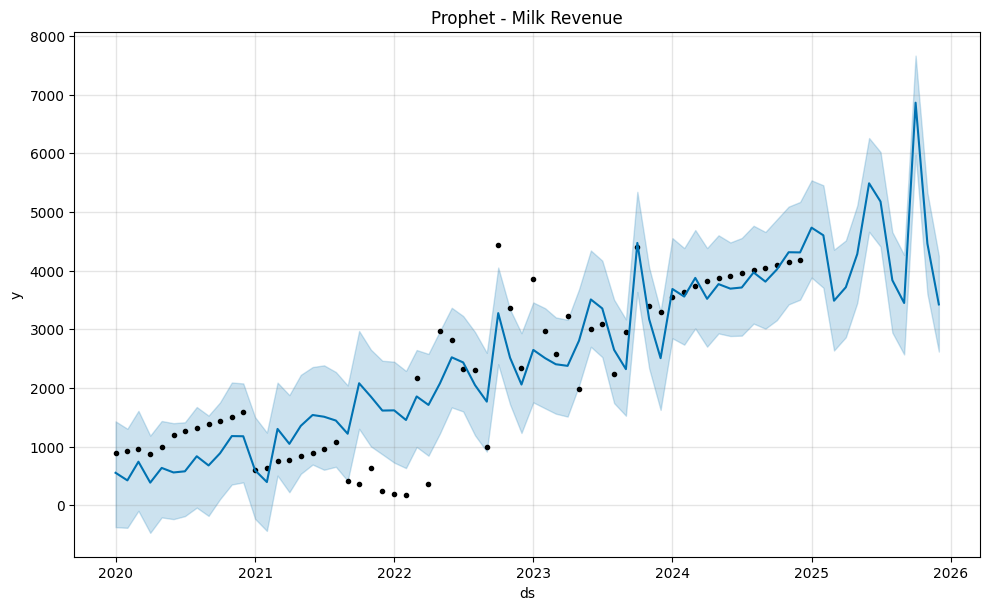

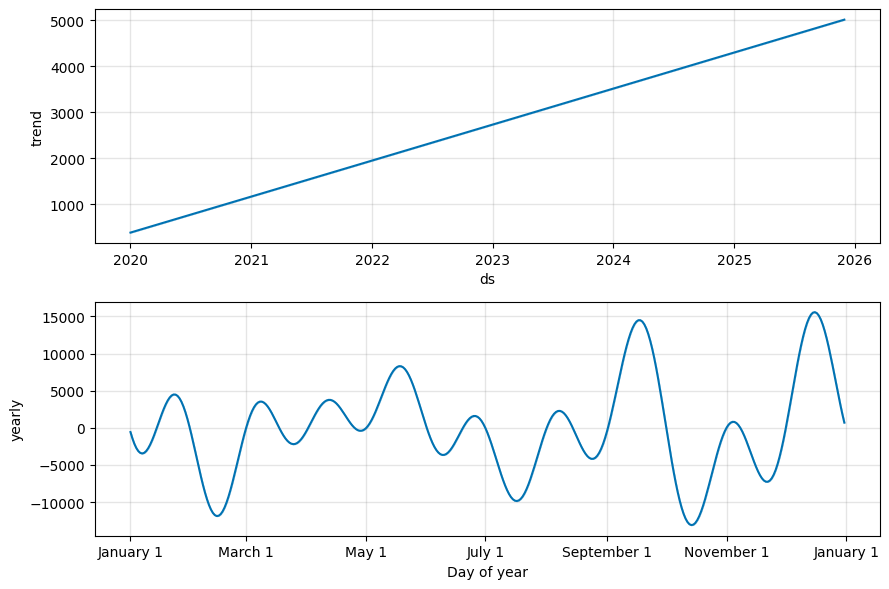

In [11]:
model_prophet_milk.plot(forecast_milk)
plt.title('Prophet - Milk Revenue')
plt.grid(True)
plt.show()

model_prophet_milk.plot_components(forecast_milk)
plt.tight_layout()
plt.show()


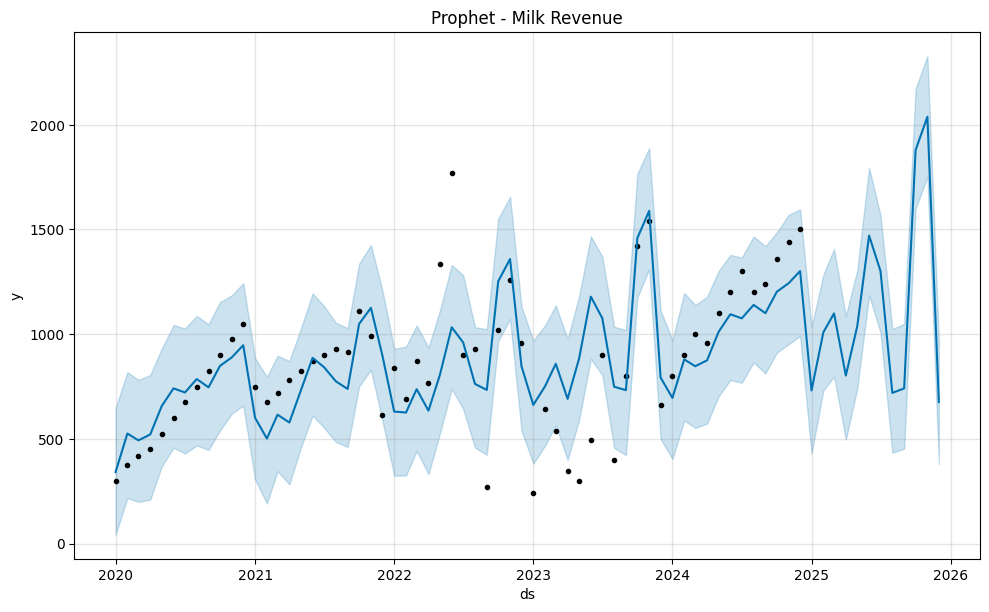

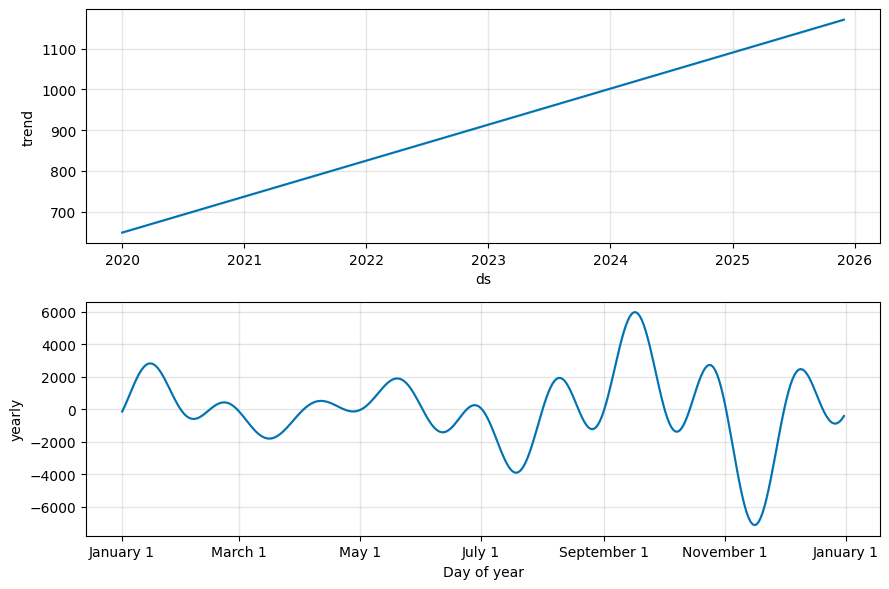

In [12]:
model_prophet_cheese.plot(forecast_cheese)
plt.title('Prophet - Milk Revenue')
plt.grid(True)
plt.show()

model_prophet_cheese.plot_components(forecast_cheese)
plt.tight_layout()
plt.show()


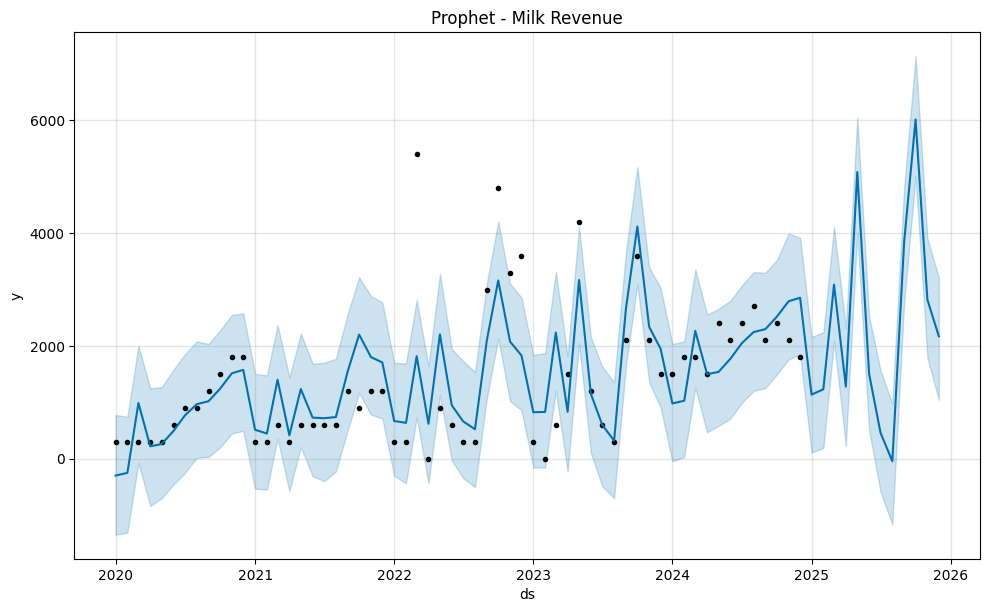

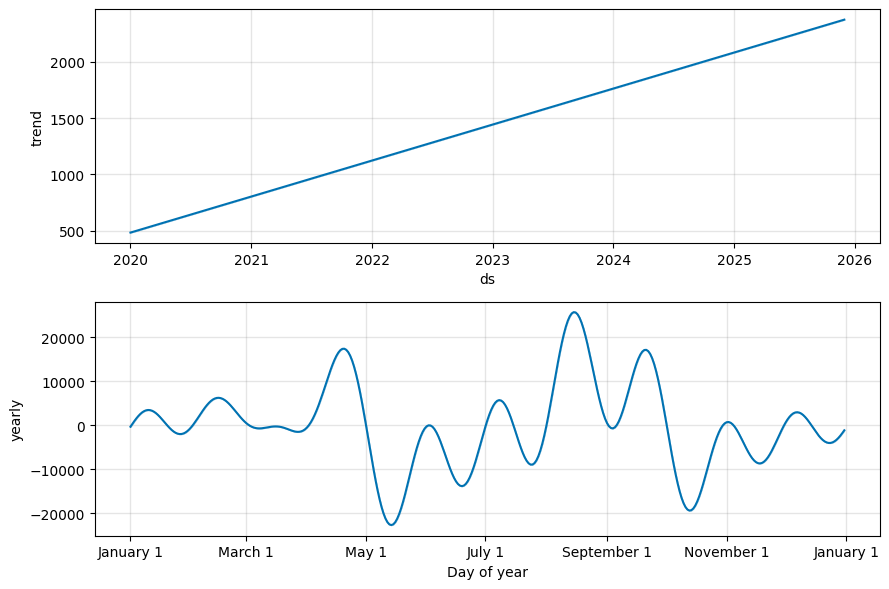

In [13]:
model_prophet_porks.plot(forecast_porks)
plt.title('Prophet - Milk Revenue')
plt.grid(True)
plt.show()

model_prophet_porks.plot_components(forecast_porks)
plt.tight_layout()
plt.show()


In [18]:
from sklearn.metrics import mean_absolute_error
df['date'] = pd.to_datetime(df['date'])
forecast_milk['ds'] = pd.to_datetime(forecast_milk['ds'])

df_eval = pd.merge(
    df[['date', 'milk_revenue']],
    forecast_milk[['ds', 'yhat']],
    left_on='date',
    right_on='ds',
    how='inner'
)
y_true = df_eval['milk_revenue']
y_pred = df_eval['yhat']

# Verifique os shapes
print(f"Shape y_true: {y_true.shape}, y_pred: {y_pred.shape}")

# Calcule MAE
if len(y_true) == len(y_pred):
    print(f"MAE: {mean_absolute_error(y_true, y_pred):.2f}")
else:
    print("Erro: y_true e y_pred têm tamanhos diferentes.")

Shape y_true: (60,), y_pred: (60,)
MAE: 520.46
